## Informação sobre o Dataset

Competição do kaggle com o objetivo de prever a idade (quantidade de anéis) de um abalone

(https://www.kaggle.com/competitions/playground-series-s4e4)

**Sexo:** Esta característica representa o gênero do abalone, categorizado como masculino (M), feminino (F) ou infantil (I).

**Comprimento:** A característica de comprimento denota a medida mais longa da concha do abalone, do ápice à base, medida em milímetros.

**Diâmetro:** O diâmetro representa a medida da concha do abalone perpendicular ao seu comprimento, também medida em milímetros.

**Altura:** Esta característica significa a altura da concha do abalone, medida perpendicularmente ao plano formado pelo comprimento e diâmetro, em milímetros.

**Peso total:** O peso total indica o peso total do abalone, abrangendo tanto a carne quanto a concha, medido em gramas.

**Peso total (Peso sem casca):** Esta característica representa o peso apenas da carne do abalone, medida em gramas. Indica a quantidade de carne extraída da concha.

**Peso total (Peso das vísceras):**  O peso das vísceras significa o peso do intestino do abalone após o sangramento, medido em gramas. Fornece insights sobre o peso dos órgãos internos do abalone.

**Peso da concha:** Esta característica representa o peso apenas da concha do abalone, excluindo a carne, medido em gramas. Fornece insights sobre a distribuição de peso entre a concha e a parte comestível do abalone.

**Anéis:** Os anéis significam o número de anéis presentes na concha do abalone, servindo como indicador da idade do abalone.



## Importação das bibliotecas e do dataframe

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install category_encoders

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
from matplotlib.ticker import FixedLocator
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import pickle

In [5]:
df = pd.read_csv('/content/drive/MyDrive/train_abalone.csv')

## Explorando o Dataset

In [6]:
df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [8]:
df.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


## Feature *Engineering*

In [9]:
df['Percentage Whole 1'] = df['Whole weight.1']/df['Whole weight']
df['Percentage Whole 2'] = df['Whole weight.2']/df['Whole weight']
df['Percentage Shell'] = df['Shell weight']/df['Whole weight']
df['Volume'] = (4/3) * np.pi * df['Length'] * (df['Diameter'] / 2)**2
df['Density'] = df['Whole weight'] / df['Volume']
df['Length to Diameter Ratio'] = df['Length'] / df['Diameter']

## Análise Exploratória dos Dados

In [10]:
numerical_features = df.select_dtypes(np.number).columns.drop('id')
numerical_features

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings', 'Percentage Whole 1',
       'Percentage Whole 2', 'Percentage Shell', 'Volume', 'Density',
       'Length to Diameter Ratio'],
      dtype='object')

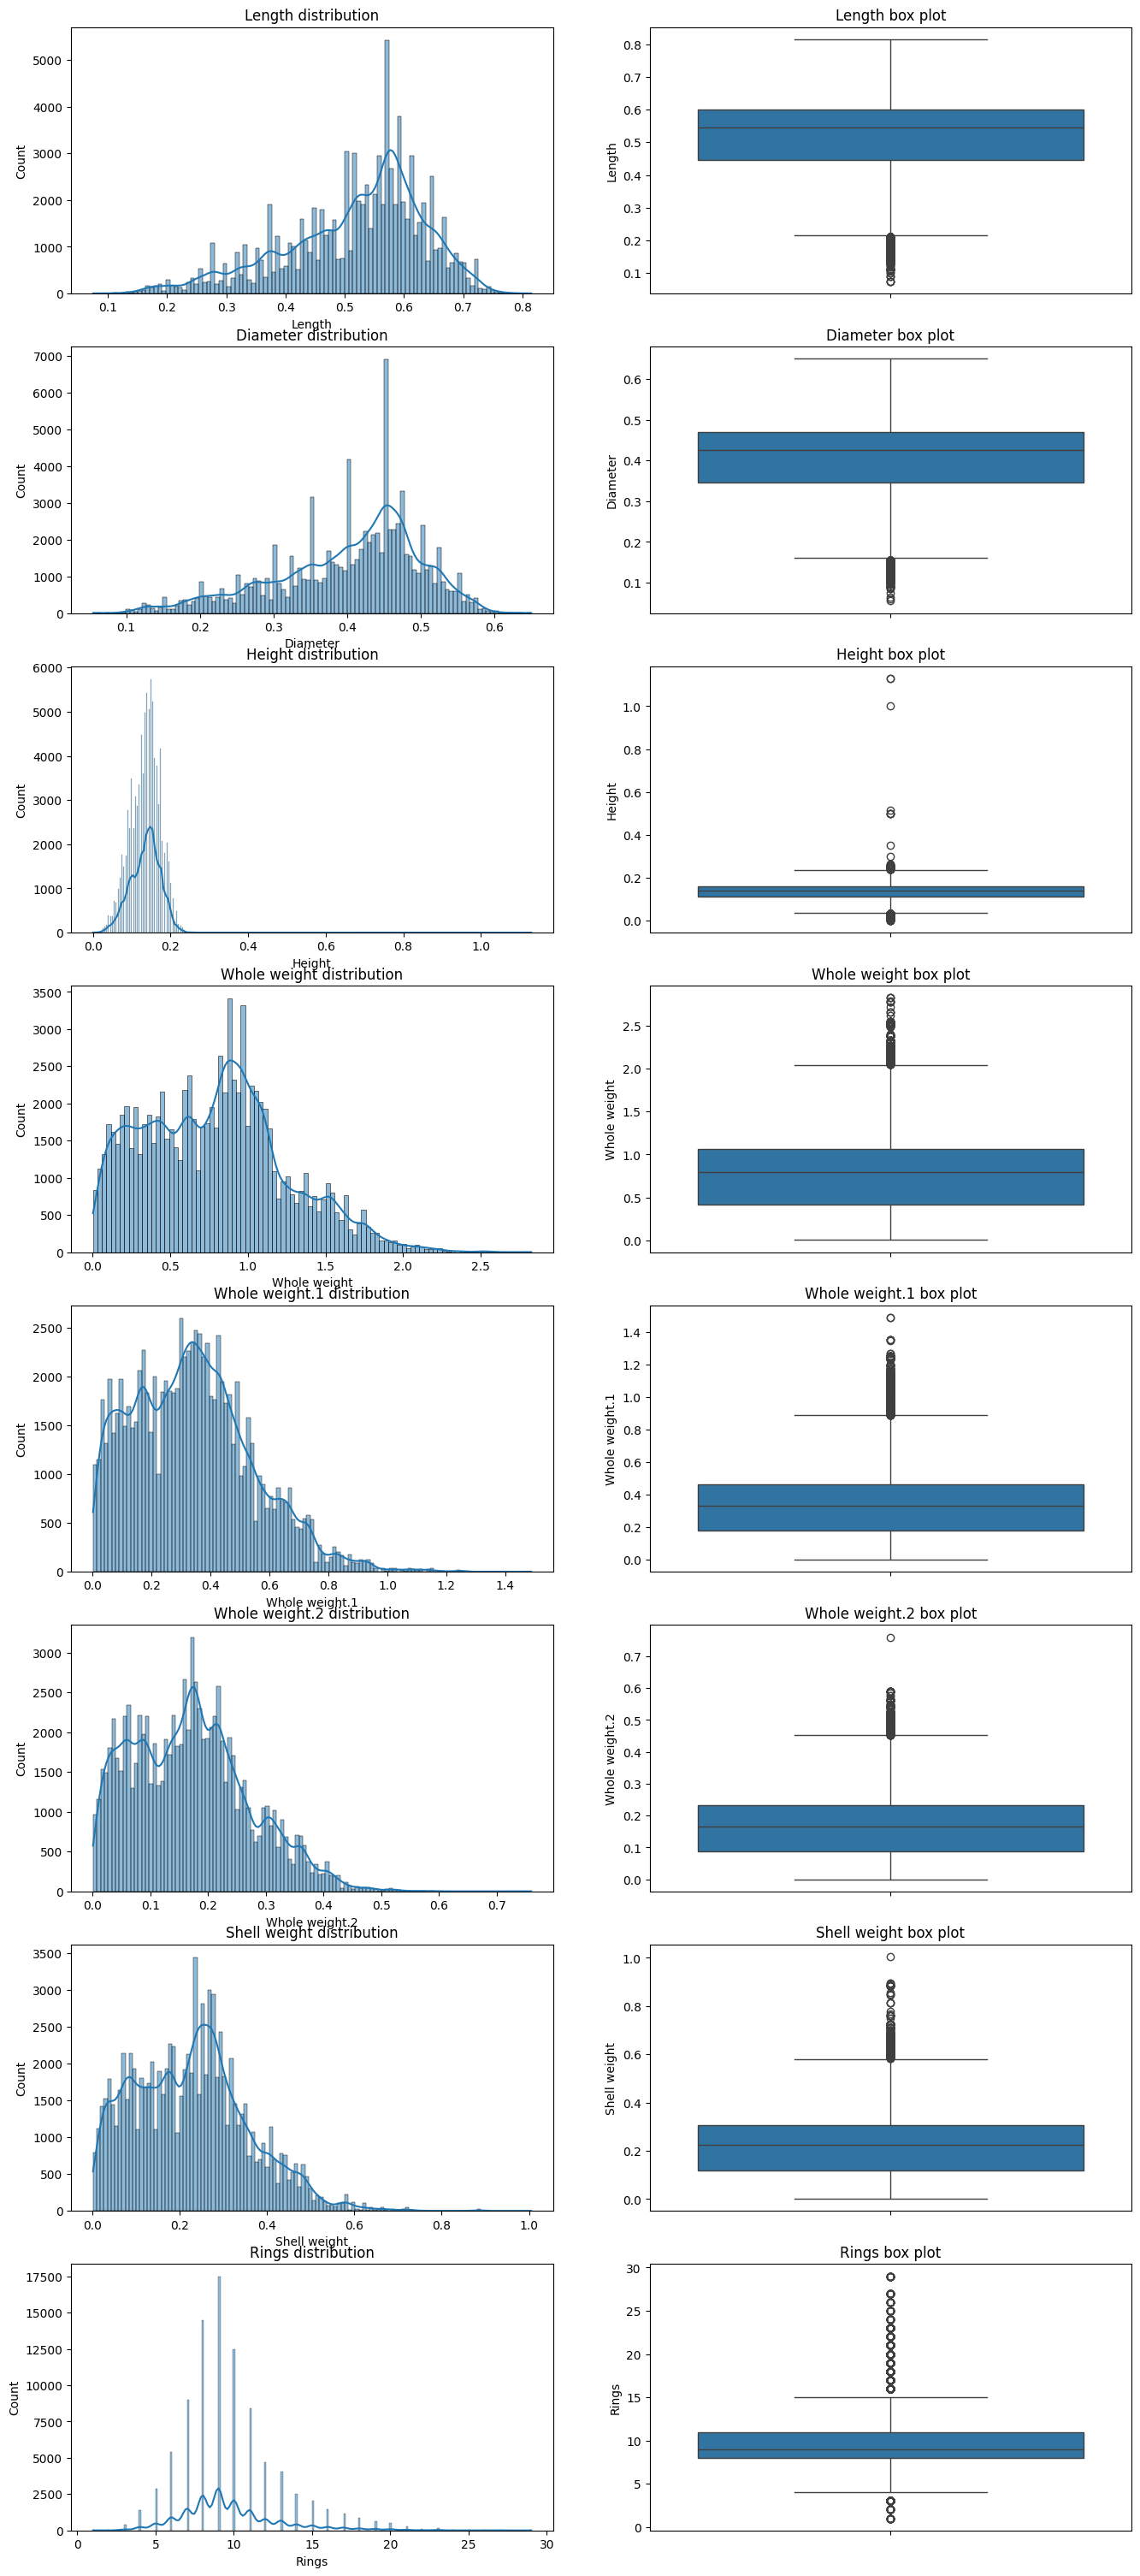

In [11]:
fig, ax = plt.subplots(8, 2, figsize = (16, 38))

for k in range(1, 16, 2):
    plt.subplot(8, 2, k)
    sns.histplot(data = df[numerical_features[floor(k/2)]], kde = True)
    title = numerical_features[floor(k/2)] + " distribution"
    plt.title(title)

    plt.subplot(8, 2, k+1)
    sns.boxplot(y = numerical_features[floor(k/2)], data = df)
    title = numerical_features[floor(k/2)] + " box plot"
    plt.title(title)

plt.show()

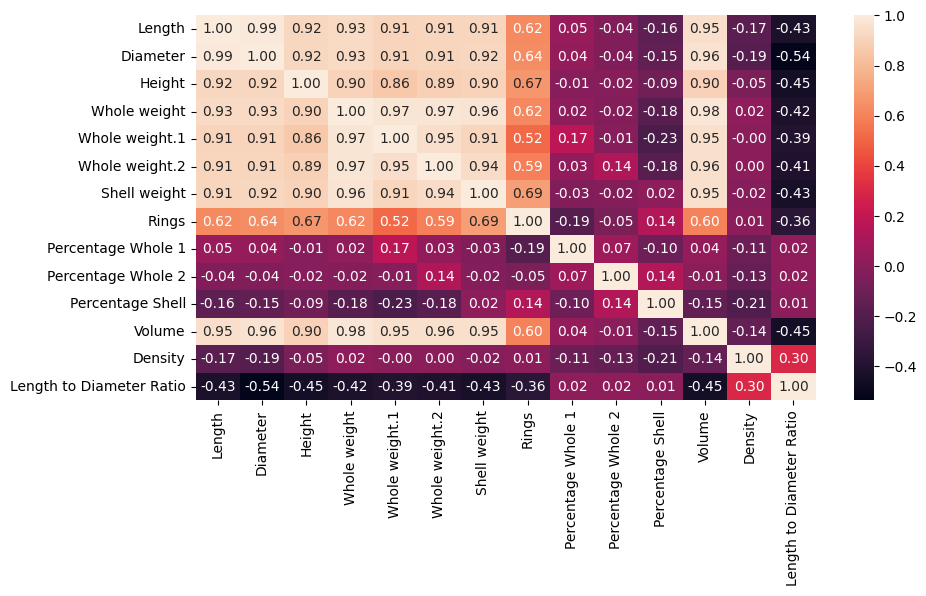

In [12]:
fig = sns.heatmap(data=df[numerical_features].corr(method='pearson'), annot=True, fmt='.2f', xticklabels=True, yticklabels=True)
fig.figure.set_size_inches(10, 5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

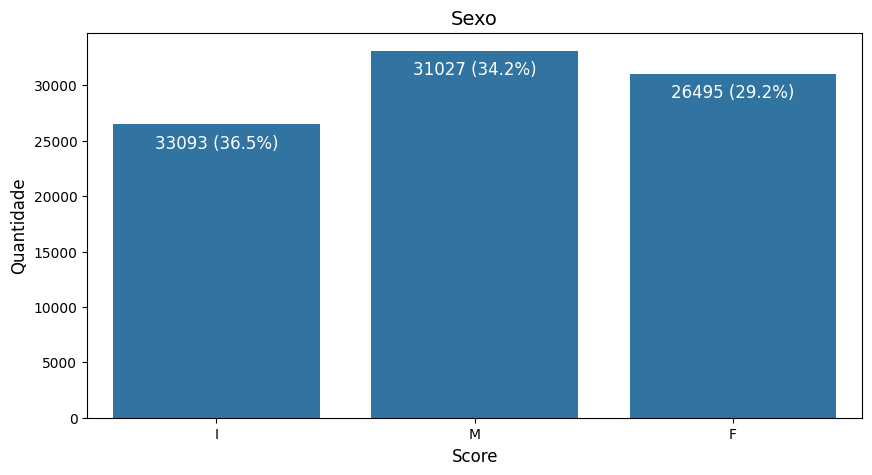

In [13]:
total = len(df['Sex'])
counts = df['Sex'].value_counts()

plt.figure(figsize=(10,5))
fig = sns.countplot(data = df, x='Sex')
fig.set_title('Sexo', fontsize=14)
fig.set_xlabel('Score', fontsize=12)
fig.set_ylabel('Quantidade', fontsize=12)
labels = [f"{v} ({v/total:.1%})" for v in counts]
fig.bar_label(fig.containers[0], labels=labels, padding=-20, color='white', fontsize=12)
fig.xaxis.set_major_locator(FixedLocator([0,1,2]))
fig.set_xticklabels(['I', 'M', 'F'])
plt.show()

## Modelagem de Dados

In [14]:
X = df.drop(['id','Rings'], axis=1)
y = df['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)

k = 5
threshold = 0.5
folds = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((63430, 14), (27185, 14), (63430,), (27185,))

In [16]:
base_models = [
    ('svr',SVR()),
    ('gb',GradientBoostingRegressor(random_state=0)),
    ('xgb',XGBRegressor(random_state=0)),
    ('knn', KNeighborsRegressor())
]

In [17]:
cat_pipeline = Pipeline([('encoder', CatBoostEncoder())])

cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, cat_cols),
        ('num', 'passthrough', num_cols)
    ])

final_model = LinearRegression()

stacking_clf = StackingRegressor(estimators=base_models, final_estimator=final_model, cv=5)



model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', stacking_clf)])


model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   CatBoostEncoder())]),
                                                  Index(['Sex'], dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Percentage Whole 1',
       'Percentage Whole 2', 'Percentage Shell', 'Volume', 'Density',
       'Length t...
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=0, ...)),
                                               ('knn', KNeighborsRegressor())],
                                   final_estimator=LinearRegression()))])

In [18]:
y_pred = model_pipeline.predict(X_test)

rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE:", rmsle)

RMSLE: 0.15038370753577843


In [31]:
with open('modelo.pkl', 'wb') as file:
    pickle.dump(model_pipeline, file)

## Usando o dataset de teste

In [19]:
df_test = pd.read_csv('/content/drive/MyDrive/test_abalone.csv')

In [20]:
df_test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [21]:
df_test['Percentage Whole 1'] = df_test['Whole weight.1']/df_test['Whole weight']
df_test['Percentage Whole 2'] = df_test['Whole weight.2']/df_test['Whole weight']
df_test['Percentage Shell'] = df_test['Shell weight']/df_test['Whole weight']
df_test['Volume'] = (4/3) * np.pi * df_test['Length'] * (df_test['Diameter'] / 2)**2
df_test['Density'] = df_test['Whole weight'] / df_test['Volume']
df_test['Length to Diameter Ratio'] = df_test['Length'] / df_test['Diameter']

In [22]:
df_test_final = df_test.drop('id', axis=1)
df_test_final.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Percentage Whole 1',
       'Percentage Whole 2', 'Percentage Shell', 'Volume', 'Density',
       'Length to Diameter Ratio'],
      dtype='object')

In [23]:
X_test_processed = preprocessor.transform(df_test_final)

In [24]:
X_test_processed_df = pd.DataFrame(X_test_processed, columns=cat_cols.tolist() + num_cols.tolist())

In [25]:
predictions = model_pipeline.predict(X_test_processed_df)

In [26]:
submission_df = pd.DataFrame({
    'id': df_test['id'],  # Substitua 'id' pelo nome da coluna de identificação no conjunto de dados de teste
    'rings': predictions
})

In [27]:
submission_df.head()

,id,rings
0,90615,9.607231
1,90616,9.679690
2,90617,10.200315
3,90618,10.701594
4,90619,7.716141


In [28]:
submission_df.to_csv('sample_submission.csv', index=False)